In [17]:
import requests
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [6]:
# tune the hyper-parameters to get a better accuracy!!!
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [7]:
# sarcasm.json
# !gdown --id 1dRzdJS7-cZS4S5CuUc32MZYSLJGkkxnp

In [8]:
# let's get the sarcasm dataset from web and transform it to json for further analysis
url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json'
datastore = requests.get(url).json()

In [9]:
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [10]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [11]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type,
                                truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type)

In [13]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 6s - loss: 0.6742 - accuracy: 0.5728 - val_loss: 0.6157 - val_accuracy: 0.7767
Epoch 2/30
625/625 - 2s - loss: 0.4380 - accuracy: 0.8260 - val_loss: 0.3799 - val_accuracy: 0.8423
Epoch 3/30
625/625 - 2s - loss: 0.3079 - accuracy: 0.8769 - val_loss: 0.3648 - val_accuracy: 0.8393
Epoch 4/30
625/625 - 2s - loss: 0.2566 - accuracy: 0.8997 - val_loss: 0.3419 - val_accuracy: 0.8574
Epoch 5/30
625/625 - 2s - loss: 0.2219 - accuracy: 0.9148 - val_loss: 0.3427 - val_accuracy: 0.8574
Epoch 6/30
625/625 - 2s - loss: 0.1937 - accuracy: 0.9257 - val_loss: 0.3609 - val_accuracy: 0.8521
Epoch 7/30
625/625 - 2s - loss: 0.1731 - accuracy: 0.9363 - val_loss: 0.3707 - val_accuracy: 0.8532
Epoch 8/30
625/625 - 2s - loss: 0.1540 - accuracy: 0.9423 - val_loss: 0.3774 - val_accuracy: 0.8547
Epoch 9/30
625/625 - 2s - loss: 0.1391 - accuracy: 0.9485 - val_loss: 0.4046 - val_accuracy: 0.8475
Epoch 10/30
625/625 - 2s - loss: 0.1242 - accuracy: 0.9574 - val_loss: 0.4215 - val_accuracy: 0.8493

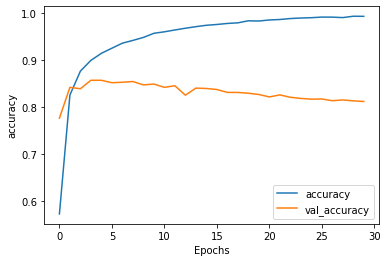

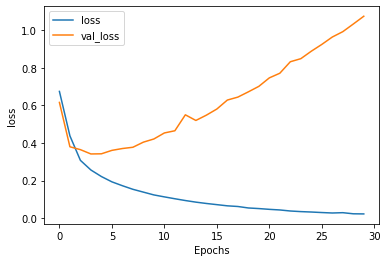

In [18]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [20]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [21]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [22]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [23]:
sentence = ["granny starting to fear spiders in the garden might be real",
            "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.3310714e-01]
 [1.8875524e-05]]
